# AI application
In this project, an image classifier will be trained to recognize different species of flowers. the classifier will be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories.

The project is broken down into multiple steps:

* Loading the image dataset and creating a pipeline.
* Building and Training an image classifier on this dataset.
* Using the trained model to perform inference on flower images.
* Building a CMD application to predict new flower

## Import Resources

In [44]:
# TODO: All necessary imports.
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import time
import numpy as np
import matplotlib.pyplot as plt
import json
import os

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.6.0
	• tf.keras version: 2.6.0
	• Running on GPU


In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

## Load the Dataset

`tensorflow_datasets` will be used to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.

In [31]:
# Load the dataset with TensorFlow Datasets. Create a training set, a validation set and a test set
(training_set, validation_set, test_set), dataset_info = tfds.load('oxford_flowers102', split=['train', 'validation', 'test'], as_supervised=True, with_info=True)

In [34]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data_path='C:\\Users\\Amr\\tensorflow_datasets\\oxford_flowers102\\2.1.1',
    download_size=328.90 MiB,
    dataset_size=331.34 MiB,
    features=FeaturesDict({
        'file_name'

## Explore the Dataset

In [35]:
# The number of examples in each set from the dataset info.
for split in dataset_info.splits:
    print(f"{split}: {dataset_info.splits[split].num_examples} examples" )

train: 1020 examples
test: 6149 examples
validation: 1020 examples


In [36]:
# The number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print(f"classes: {num_classes}")

classes: 102


In [38]:
# The shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    image = image.numpy()
    label = label.numpy()
    print(f"image shape: {image.shape}, label: {label}")


image shape: (500, 667, 3), label: 72
image shape: (500, 666, 3), label: 84
image shape: (670, 500, 3), label: 70


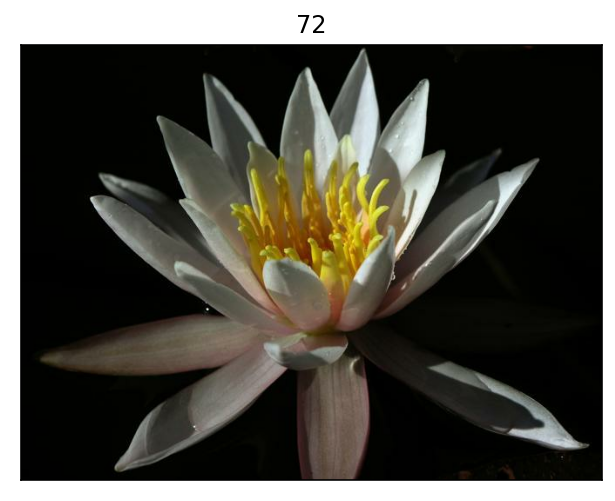

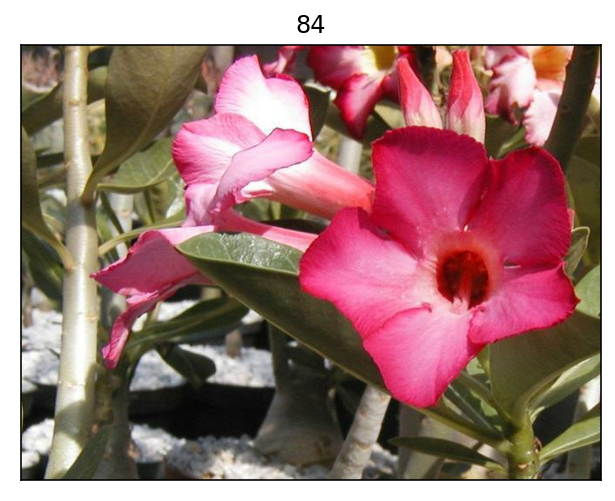

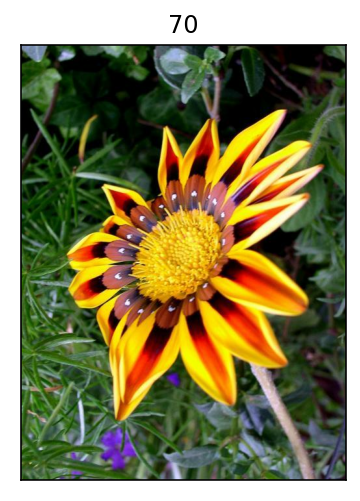

In [42]:
# Plot 1 image from the training set. Set the title of the plot to the corresponding image label. 
for image, label in training_set.take(3):
    image = image.numpy()
    label = label.numpy()
    plt.title(label)
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.show()


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [45]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

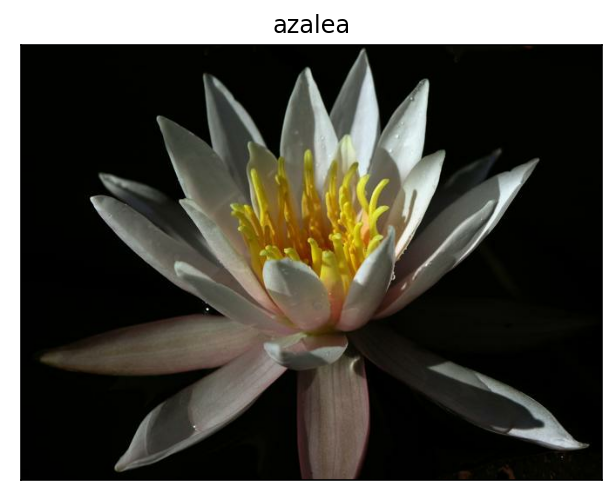

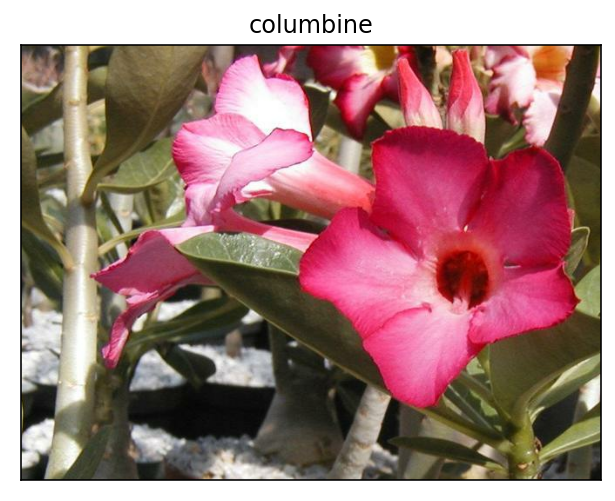

In [55]:
# Plot 1 image from the training set. Set the title of the plot to the corresponding class name. 
for image, label in training_set.take(2):
    image = image.numpy()
    label = class_names[str(label.numpy())]
    plt.title(label)
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.show()



## Create Pipeline

In [93]:
# The pipeline for each set.
# Batching of the datasets
batch_size = 32
image_size = 224

num_training_examples = dataset_info.splits['train'].num_examples

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

training_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)


# Build and Train the Classifier
The MobileNet pre-trained model from TensorFlow Hub will be used to get the image features. Then, build and train a new feed-forward classifier using those features.
* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

In [99]:
# Build and train your network.
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))
feature_extractor.trainable = False

In [101]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [102]:
training_clock = f"{time.localtime().tm_mon}_{time.localtime().tm_mday}_{time.localtime().tm_hour}_{time.localtime().tm_min}"

best_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"./model/best_model_{training_clock}.h5",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # min_delta=0.001,
    patience=10,
    mode='min',
)


In [103]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 30

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks = [best_model_checkpoint, model_early_stop])

Epoch 1/30
32/32 [==============================] - 6s 90ms/step - loss: 4.2651 - accuracy: 0.1147 - val_loss: 3.0964 - val_accuracy: 0.3951
Epoch 2/30
32/32 [==============================] - 3s 78ms/step - loss: 2.0748 - accuracy: 0.6902 - val_loss: 2.0098 - val_accuracy: 0.6353
Epoch 3/30
32/32 [==============================] - 3s 78ms/step - loss: 1.1006 - accuracy: 0.9049 - val_loss: 1.5374 - val_accuracy: 0.7176
Epoch 4/30
32/32 [==============================] - 3s 80ms/step - loss: 0.6682 - accuracy: 0.9578 - val_loss: 1.3022 - val_accuracy: 0.7588
Epoch 5/30
32/32 [==============================] - 3s 78ms/step - loss: 0.4440 - accuracy: 0.9824 - val_loss: 1.1564 - val_accuracy: 0.7814
Epoch 6/30
32/32 [==============================] - 3s 79ms/step - loss: 0.3179 - accuracy: 0.9912 - val_loss: 1.0697 - val_accuracy: 0.7922
Epoch 7/30
32/32 [==============================] - 3s 81ms/step - loss: 0.2369 - accuracy: 0.9990 - val_loss: 1.0092 - val_accuracy: 0.7873
Epoch 8/30
32

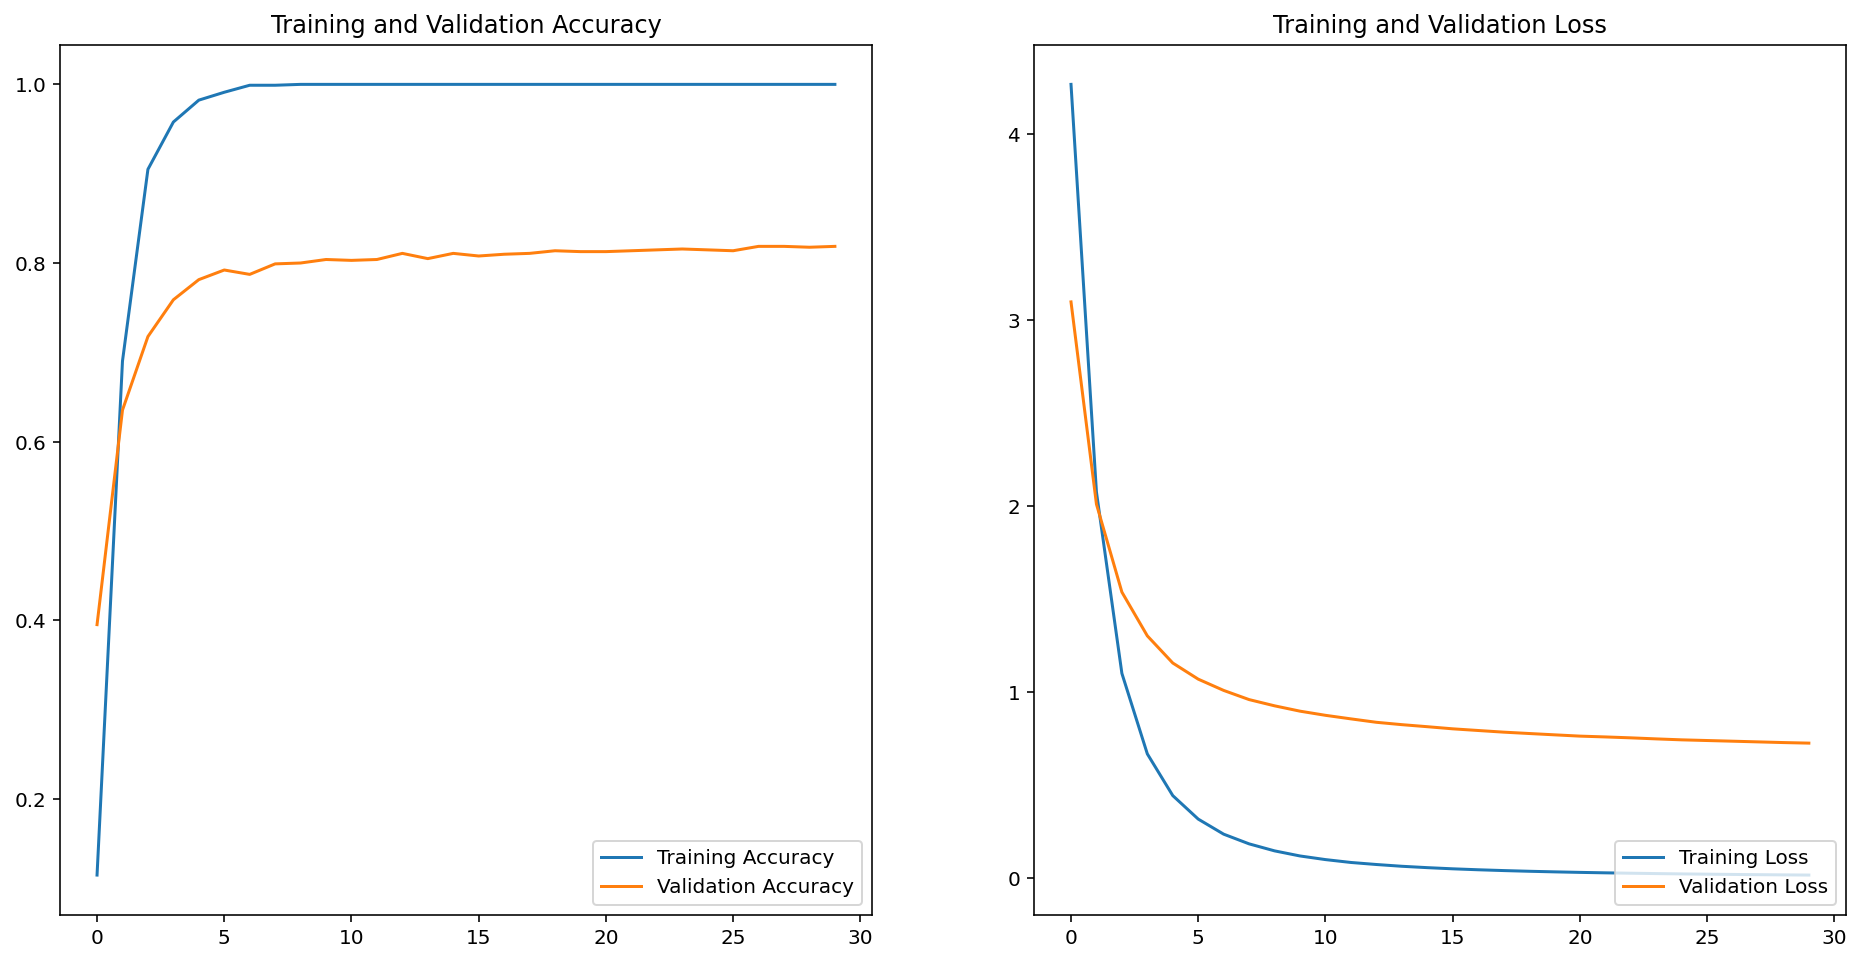

In [104]:
# Plot the loss and accuracy values achieved during training.

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

## Testing your Network

In [105]:
# Print the loss and accuracy values achieved on the entire test set.
test_history = model.evaluate(testing_batches)
print(f"Test Loss: {test_history[0]}")
print(f"Test Accuracy: {test_history[1]}")


193/193 [==============================] - 8s 39ms/step - loss: 0.8627 - accuracy: 0.7826
Test Loss: 0.86274254322052
Test Accuracy: 0.782566249370575


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [106]:
# Save your trained model as a Keras model.
model.save("./model/best_model.h5")

## Load the Keras Model

Load the Keras model you saved above.

In [108]:
# Load the best Keras model saved 
loaded_model = tf.keras.models.load_model("./model/best_model.h5", custom_objects={'KerasLayer': hub.KerasLayer})

# Inference for Classification

### Image Pre-processing
A `process_image` function will pre-process the input image to match pre-processing of the training data. the `process_image` function will be called from the `predict` function.  
The `process_image` function should will take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.
* Convert image into a TensorFlow Tensor.
* Resize it to the appropriate size using `tf.image.resize`.
* Normalize the pixel values. 

In [233]:
# TODO: Create the process_image function
image_size = 224
def process_image(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image

### checking the pre-processing function

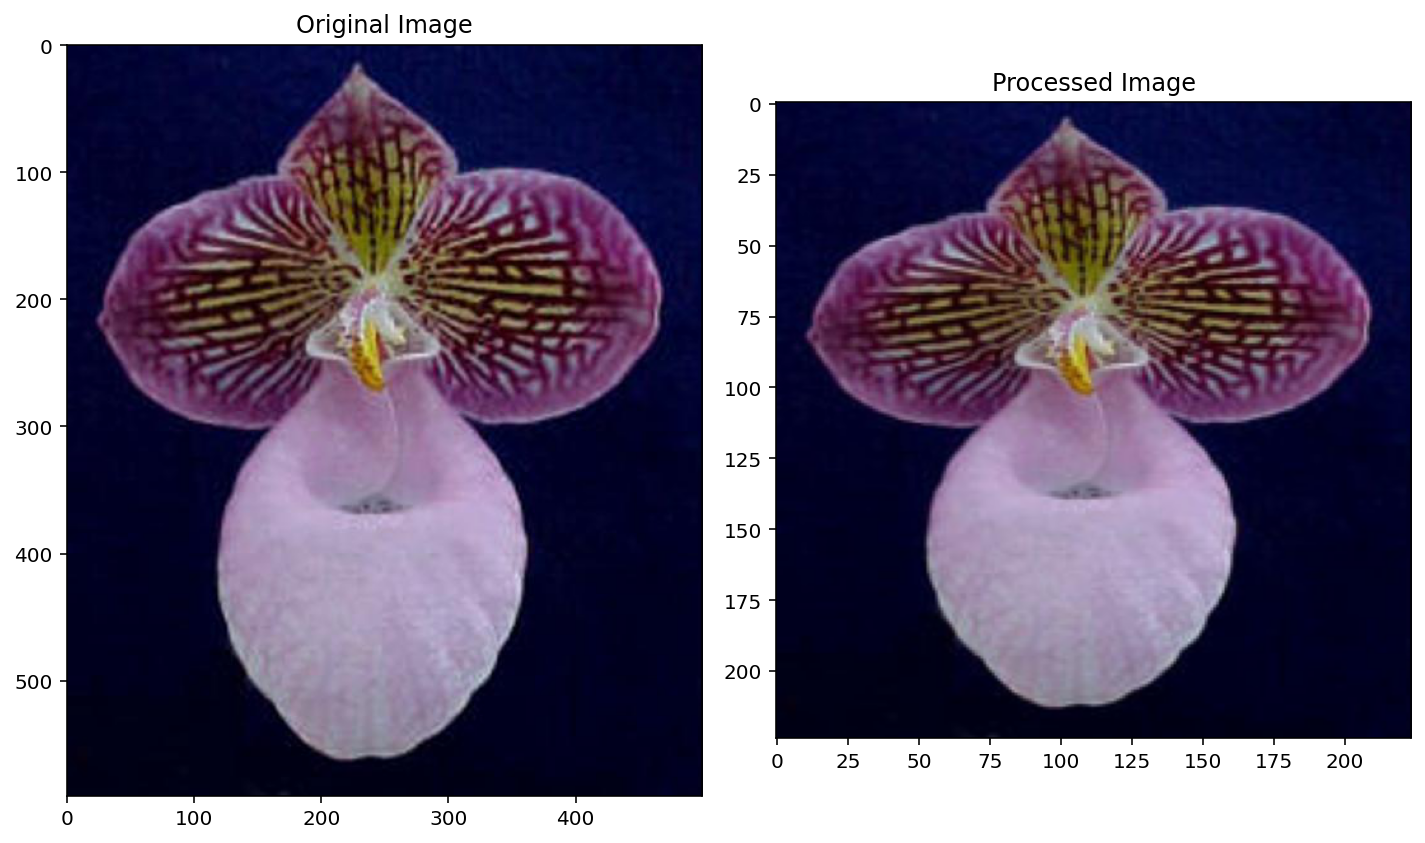

In [234]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

### Inference
A function called `predict` will be used to take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

**Note:** The image returned by the `process_image` have shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size.  
The `np.expand_dims()` function will add the extra dimension. 

In [235]:
# Predict function

def predict(image_path, inference_model, number_of_predictions):
    image = Image.open(image_path)
    image = np.asarray(image)
    processed_image = process_image(image)
    processed_image = np.expand_dims(processed_image, axis=0)
    predictions = inference_model.predict(processed_image)
    probs, labels = tf.nn.top_k(predictions[0], k=number_of_predictions)
    return probs, labels


# Sanity Check

Check the predictions made the model to make sure they are correct. This will be done on 4 images in the `./test_images/` folder:
* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

A plot of the input image alongside the probabilities for the top 5 classes predicted by model will be used for the check

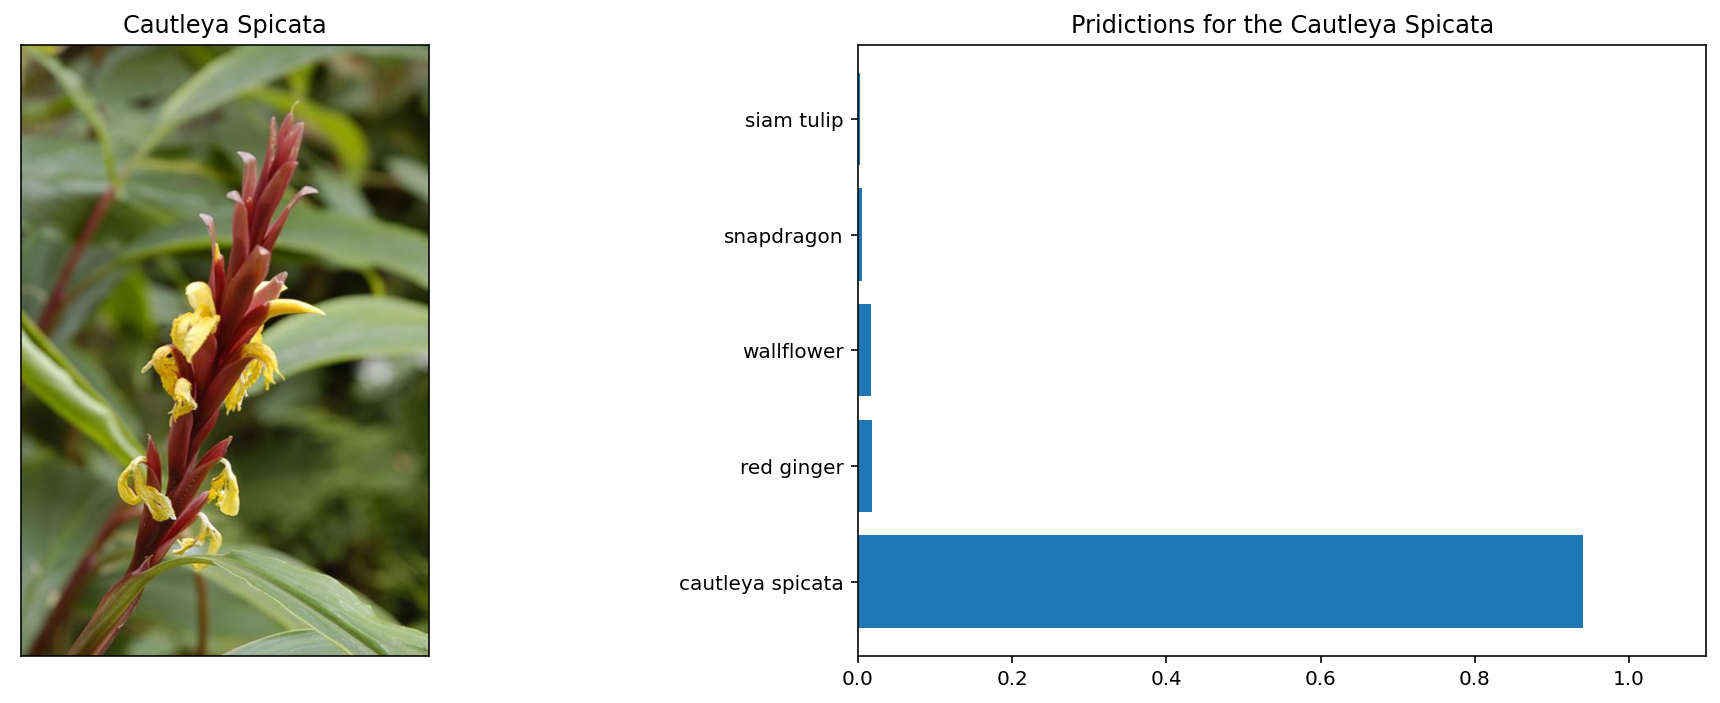

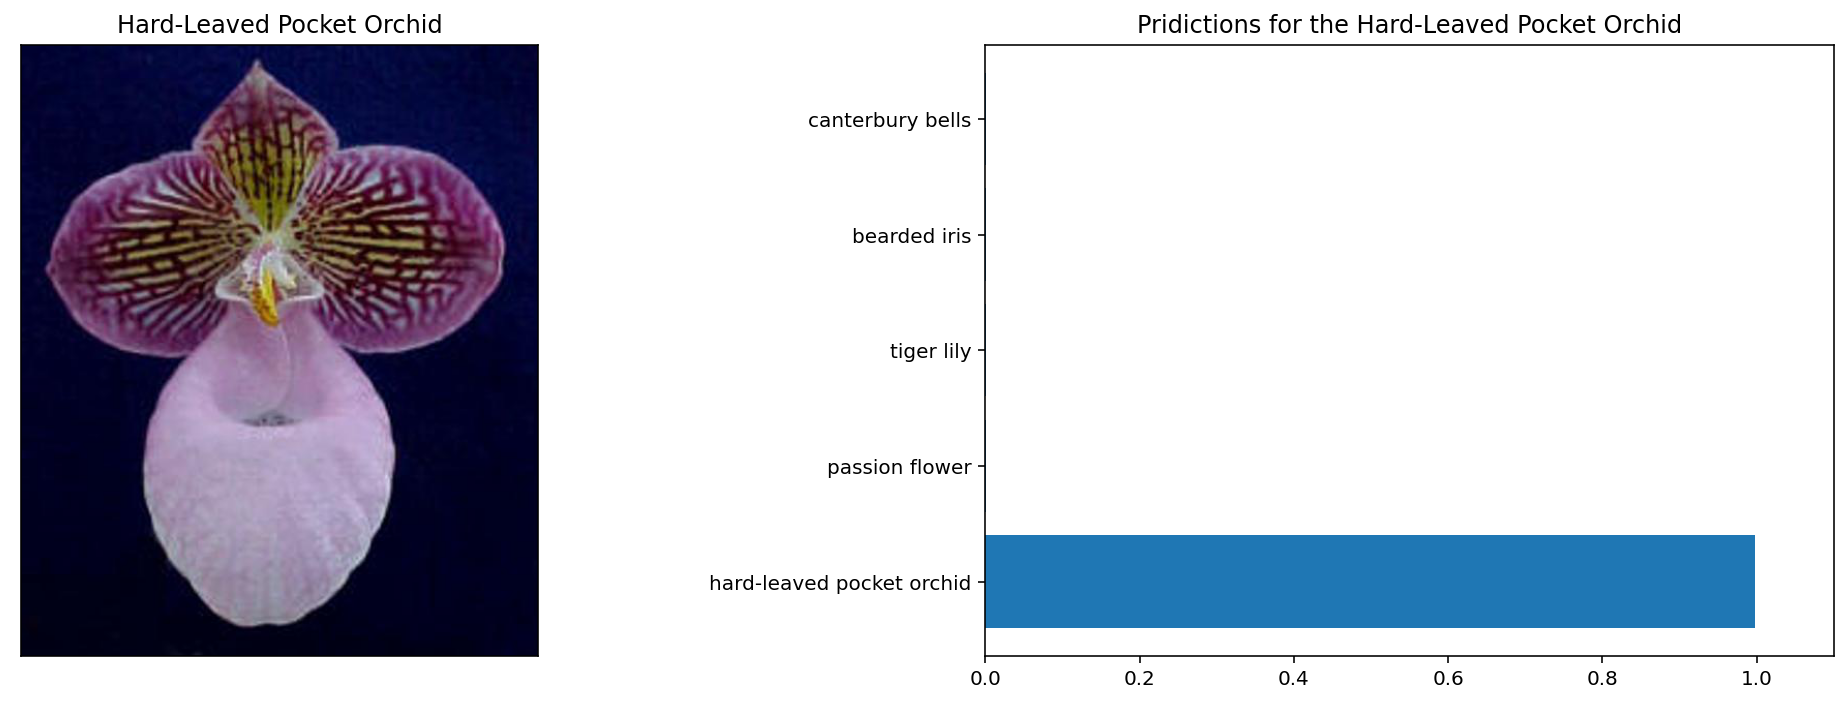

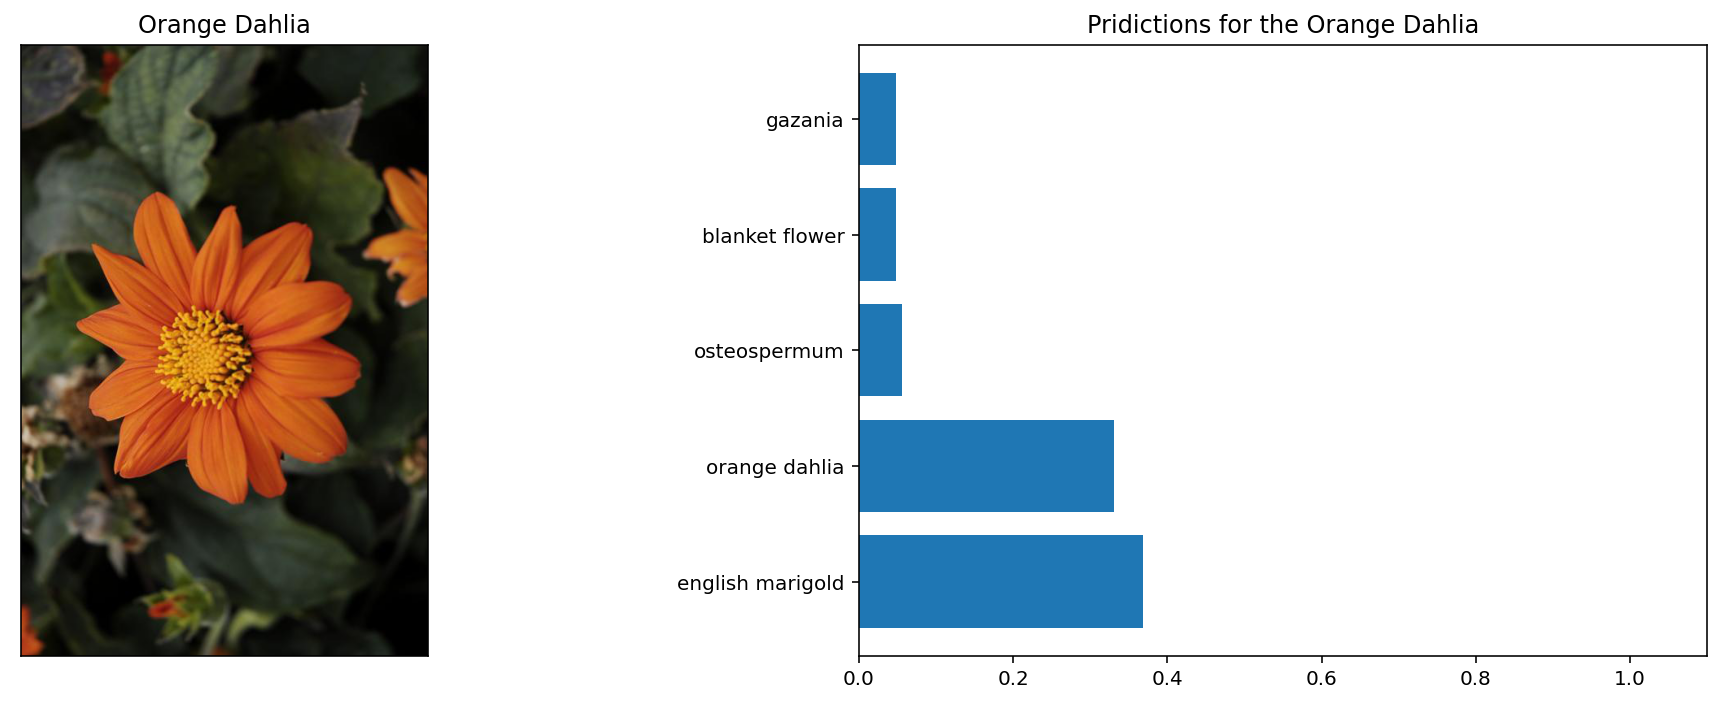

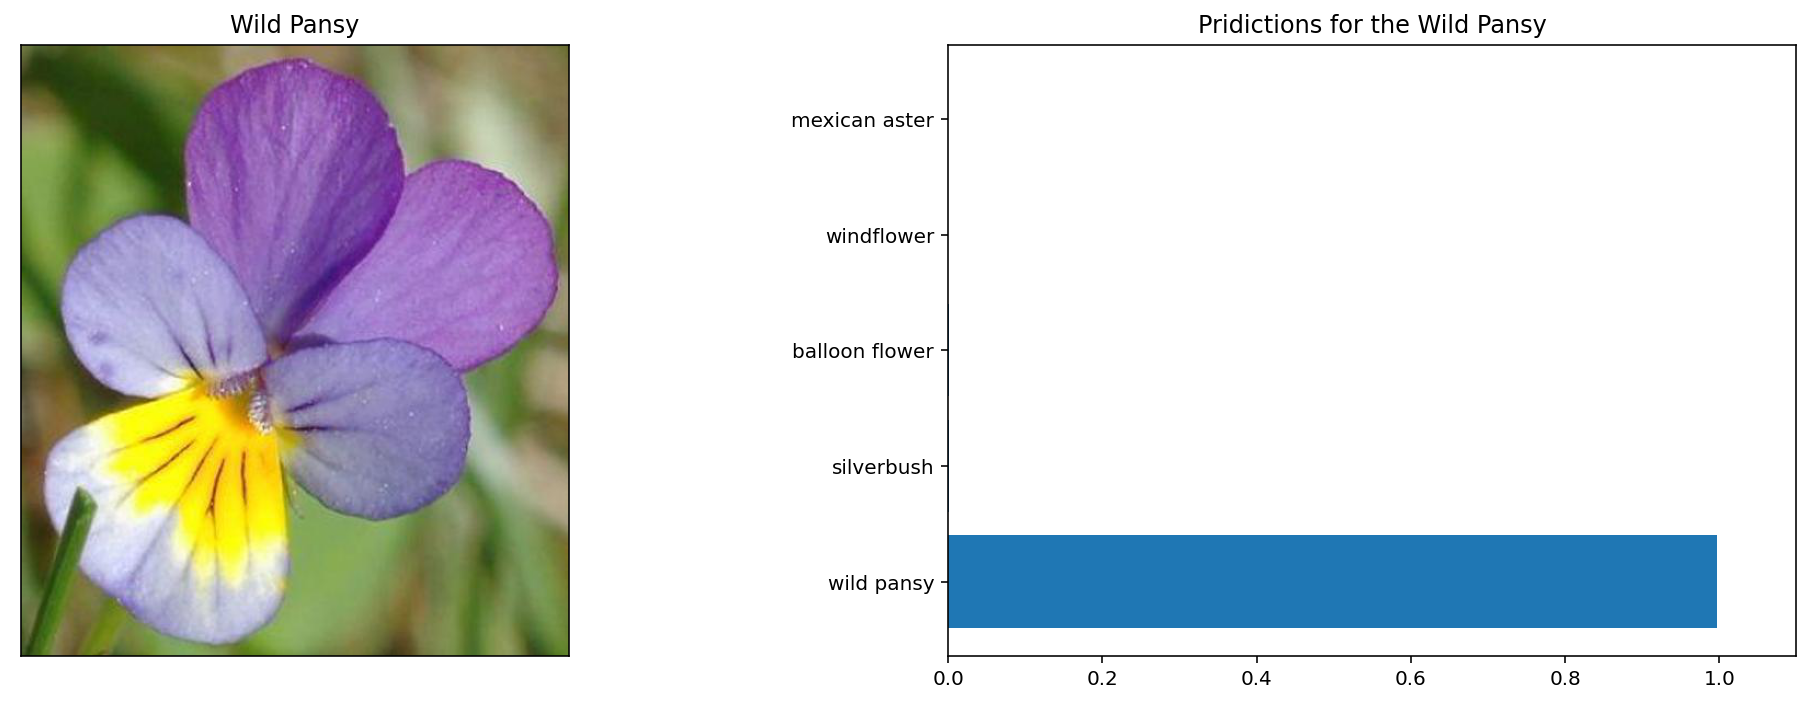

In [298]:
# TODO: Plot the input image along with the top 5 classes
for image in os.listdir("./test_images"):
    flower_name = image.replace(".jpg", "").replace("_", " ").title()
    flower_path = os.path.join(".\\test_images", image)

    values, labels = predict(flower_path, loaded_model, 5)
    classes = [class_names[str(c+1)] for c in labels.numpy()]

    fig, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    ax1.imshow(Image.open(flower_path))
    ax1.set_title(flower_name)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax2.barh(classes, values)
    ax2.set_xlim(0,1.1)
    ax2.set_aspect(0.15)
    ax2.set_title(f"Pridictions for the {flower_name}")
    plt.tight_layout()